# **Extract Information from Table Images**

The purpose of this article is to extract information from a tabular image and store them directly as excel files. There are three steps to do this:

> * Detecting the cells in the image
> * Retrieving cells position
> * Text extraction and placing in the cells

## **Data loading**

Before we get into the implementation we will choose the image from which we need to extract the images. Let us choose a simple table with a few columns. The image I have selected is shown below.

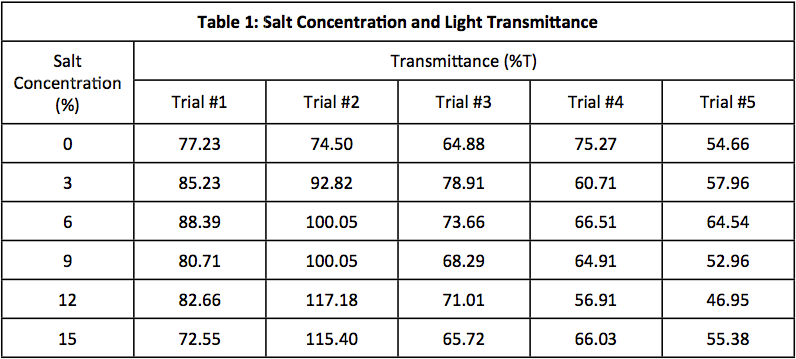

This table contains information about salt concentration in some experiments and their results are noted. You can download this by clicking on the [link](https://mrkremerscience.com/2013/08/28/making-scientific-data-tables/). 

Now, we will import the required libraries and load the dataset

In [ ]:
!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk gensim scikit-image opencv-python pillow dlib --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# !wget https://mrkremerscience.files.wordpress.com/2013/08/data-table-example1.png

--2021-10-28 14:42:01--  https://mrkremerscience.files.wordpress.com/2013/08/data-table-example1.png
Resolving mrkremerscience.files.wordpress.com (mrkremerscience.files.wordpress.com)... 192.0.72.26, 192.0.72.27
Connecting to mrkremerscience.files.wordpress.com (mrkremerscience.files.wordpress.com)|192.0.72.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33681 (33K) [image/png]
Saving to: ‘data-table-example1.png’

data-table-example1 100%[===================>]  32.89K  --.-KB/s    in 0.04s   

2021-10-28 14:42:01 (832 KB/s) - ‘data-table-example1.png’ saved [33681/33681]



In [ ]:
sample=r'data-table-example1.png'
read_image= cv2.imread(sample,0)

After importing the data and loading it, we will now start with the first step. 

## **Detecting the cells**

For the purpose of converting an image to excel we need to first detect the cells that are the horizontal and vertical lines that form the cells. To do this, we need to first convert the image to binary and turn them into grayscale with OpenCV.

In [ ]:
convert_bin,grey_scale = cv2.threshold(read_image,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
grey_scale = 255-grey_scale
grey_graph = plt.imshow(grey_scale,cmap='gray')
plt.show()

Here, we have converted the image into a binary format. Now let us define two kernels to extract the horizontal and vertical lines from these cells. 

For the horizontal lines, we will do the following. We will first get the entire image dimensions and then using the OpenCV structural element function we will get the horizontal lines. 

In [ ]:
length = np.array(read_image).shape[1]//100
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, 1))

Now, using the erode and dilate function we will apply it to our image and detect and extract the horizontal lines.

In [ ]:
horizontal_detect = cv2.erode(grey_scale, horizontal_kernel, iterations=3)
hor_line = cv2.dilate(horizontal_detect, horizontal_kernel, iterations=3)
plotting = plt.imshow(horizontal_detect,cmap='gray')
plt.show()

In the same way, we will repeat these steps to detect the vertical lines by building another kernel. 

In [ ]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, length))
vertical_detect = cv2.erode(grey_scale, vertical_kernel, iterations=3)
ver_lines = cv2.dilate(vertical_detect, vertical_kernel, iterations=3)
show = plt.imshow(vertical_detect,cmap='gray')
plt.show()

Once we have these ready, all we need to do is combine them and make them into a grid-like structure and get a clear tabular representation without the content inside. To do this, we will first combine the vertical and horizontal lines and create a final rectangular kernel. Then we will convert the image back from greyscale to white. 

In [ ]:
final = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
combine = cv2.addWeighted(ver_lines, 0.5, hor_line, 0.5, 0.0)
combine = cv2.erode(~combine, final, iterations=2)
thresh, combine = cv2.threshold(combine,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
convert_xor = cv2.bitwise_xor(read_image,combine)
inverse = cv2.bitwise_not(convert_xor)
output= plt.imshow(inverse,cmap='gray')
plt.show()

This shows the final combined table where the cells are present. 

## **Retrieving the cell positions**

Now that we have our empty table ready, we need to find the right location to add the text. That is the column and the row where the text needs to be inserted. To do this, we need to get bounding boxes around each cell. Contours are the best way to highlight the cell lines and determine the bounding boxes. Let us now write a function to get the contours and the bounding box. It is also important to make sure the contours are read in a particular order which will be written in the function. 

In [ ]:
cont, _ = cv2.findContours(combine, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
def get_boxes(num, method="left-to-right"):
    invert = False
    flag = 0
    if method == "right-to-left" or method == "bottom-to-top":
        invert = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        flag = 1
    boxes = [cv2.boundingRect(c) for c in num]
    (num, boxes) = zip(*sorted(zip(num, boxes),key=lambda b:b[1][1], reverse=invert))
    return (num, boxes)
cont, boxes = get_boxes(cont, method="top-to-bottom")

Next, we will retrieve the dimensions of each contour and store them. Since these contours and rectangles, we will have 4 sides. We need to set the dimensions which are up to the user. Here I have set the width to be 500 and height to be 500. These values depend on the size of the image. 

In [ ]:
final_box = []
for c in cont:
    s1, s2, s3, s4 = cv2.boundingRect(c)
    if (s3<500 and s4<500):
        rectangle_img = cv2.rectangle(read_image,(s1,s2),(s1+s3,s2+s4),(0,255,0),2)
        final_box.append([s1,s2,s3,s4])
graph = plt.imshow(rectangle_img,cmap='gray')
plt.show()

You can see the boxes are highlighted as shown above and we have the position of each cell of the image stored in the list. But we also need the location of each of the cells so that they can be extracted in order. To get the location we will take the average value of the boxes and then add the height and width with them. Then we will sort them into respective boxes and find the midpoint of these boxes so that they can be aligned well.

In [ ]:
dim = [boxes[i][3] for i in range(len(boxes))]
avg = np.mean(dim)
hor=[]
ver=[]
for i in range(len(final_box)):    
    if(i==0):
        ver.append(final_box[i])
        last=final_box[i]    
    else:
        if(final_box[i][1]<=last[1]+avg/2):
            ver.append(final_box[i])
            last=final_box[i]            
            if(i==len(final_box)-1):
                hor.append(ver)        
        else:
            hor.append(ver)
            ver=[]
            last = final_box[i]
            ver.append(final_box[i])
total = 0
for i in range(len(hor)):
    total = len(hor[i])
    if total > total:
        total = total
mid = [int(hor[i][j][0]+hor[i][j][2]/2) for j in range(len(hor[i])) if hor[0]]
mid=np.array(mid)
mid.sort()

## **Value Extraction**

Since we have the boxes, and the dimensions along with the midpoint we can now move on to our text extraction. But before that, we will make sure that our cells are in the correct order. To do this, follow these steps.

In [ ]:
order = []
for i in range(len(hor)):
    arrange=[]
    for k in range(total):
        arrange.append([])
    for j in range(len(hor[i])):
        sub = abs(mid-(hor[i][j][0]+hor[i][j][2]/4))
        lowest = min(sub)
        idx = list(sub).index(lowest)
        arrange[idx].append(hor[i][j])
    order.append(arrange)

Now we will use the pytesseract to perform OCR since it is compatible with OpenCV and Python. 

In [ ]:
!python -m pip install pytesseract --user -q
# !sudo apt install tesseract-ocr

In [ ]:
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

We will take every box and perform eroding and dilating on it and then extract the information in the cells with OCR.

In [ ]:
extract=[]
for i in range(len(order)):
    for j in range(len(order[i])):
        inside=''
        if(len(order[i][j])==0):
            extract.append(' ')
        else:
            for k in range(len(order[i][j])):
                side1,side2,width,height = order[i][j][k][0],order[i][j][k][1], order[i][j][k][2],order[i][j][k][3]
                final_extract = inverse[side2:side2+height, side1:side1+width]
                final_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                get_border = cv2.copyMakeBorder(final_extract,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resize = cv2.resize(get_border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dil = cv2.dilate(resize, final_kernel,iterations=1)
                ero = cv2.erode(dil, final_kernel,iterations=2)
                ocr = pytesseract.image_to_string(ero)
                if(len(ocr)==0):
                    ocr = pytesseract.image_to_string(ero, config='--psm 3')
                inside = inside +" "+ ocr
            extract.append(inside)

Now we will convert this extracted array into a dataframe and write it to an excel file. 

In [ ]:
a = np.array(extract)
dataset = pd.DataFrame(a.reshape(len(hor), total))
dataset

In [ ]:
!python -m pip install xlsxwriter --user -q

In [ ]:
# dataset.to_excel("test.xlsx", engine='xlsxwriter')

#**Related Articles:**

> * [OpenCV to Extract Information From Table Images](https://analyticsindiamag.com/how-to-use-opencv-to-extract-information-from-table-images/)

> * [Credit Card Reader](https://analyticsindiamag.com/how-i-created-the-credit-card-reader-using-opencv/)

> * [Real Time GUI Interactions with OpenCV](https://analyticsindiamag.com/real-time-gui-interactions-with-opencv-in-python/)

> * [Image Processing with OpenCV](https://analyticsindiamag.com/image-processing-with-opencv-in-python/)

> * [Getting started with OpenCV]((https://analyticsindiamag.com/getting-started-with-opencv-in-python/))

